In [1]:
import arviz as az
import matplotlib.pylab as plt
import matplotlib as mpl
mpl.style.use('plotting.mplstyle')
import numpy as np
np.random.seed(11)
import json
import h5py
import os
from read_O3_LVK_results import *

In [2]:
# Load AR results
precomputed_data = h5py.File("./../data/ar_lnm1_q_summary.hdf","r")
qs = precomputed_data['posterior/qs'][()]
dR_dqs = precomputed_data['posterior/dR_dqs'][()]

## 1. Directly plot results of AR primary mass modeling alongside LVK result

In [3]:
# Read out the posterior on the merger R(m1,q) as a function of m1 and q, as measured by the LVK
# Below, we will have to do two further things: (i) convert to a merger rate per *log* mass,
# and (ii) evaluate this at our reference primary mass m1=20

lvk_m1_grid,lvk_q_grid,lvk_R_m1s_qs = get_lvk_m1_q(1000)

/Users/tcallister/Documents/Repositories/autoregressive-bbh-inference/figures/read_O3_LVK_results.py:182: RuntimeWarning: overflow encountered in exp
  q_smoothing[to_smooth] = 1./(np.exp(delta_m/((Q*M)[to_smooth]-mMin) + delta_m/((Q*M)[to_smooth]-mMin-delta_m))+1.)
/Users/tcallister/Documents/Repositories/autoregressive-bbh-inference/figures/read_O3_LVK_results.py:192: RuntimeWarning: invalid value encountered in true_divide
  p_q = p_q_unnormed/np.trapz(p_q_unnormed,q_grid,axis=0)
/Users/tcallister/Documents/Repositories/autoregressive-bbh-inference/figures/read_O3_LVK_results.py:186: RuntimeWarning: divide by zero encountered in power
  p_q_unnormed = Q**bq/(1.-(mMin/M)**(1.+bq))*q_smoothing
/Users/tcallister/Documents/Repositories/autoregressive-bbh-inference/figures/read_O3_LVK_results.py:186: RuntimeWarning: invalid value encountered in multiply
  p_q_unnormed = Q**bq/(1.-(mMin/M)**(1.+bq))*q_smoothing
/Users/tcallister/Documents/Repositories/autoregressive-bbh-inference/figures/

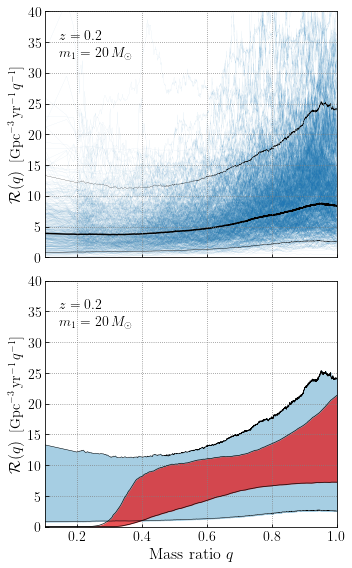

In [4]:
###########################################
# First make our "trace plot" of AR results
###########################################

fig = plt.figure(figsize=(5,8))
ax = fig.add_subplot(211)
ax.set_rasterization_zorder(2)

# Plot a random subset of AR samples
for i in np.random.choice(range(dR_dqs.shape[1]),size=500,replace=False):                 
    ax.plot(qs,dR_dqs[:,i],color='#1f78b4',alpha=0.3,lw=0.1,zorder=0)

# Highlight median and 90% bounds
ax.plot(qs,np.median(dR_dqs,axis=1),color='black',zorder=1)
ax.plot(qs,np.quantile(dR_dqs,0.05,axis=1),color='black',lw=0.4,zorder=1)
ax.plot(qs,np.quantile(dR_dqs,0.95,axis=1),color='black',lw=0.2,zorder=1)

# Misc formatting
ax.tick_params(labelsize=14)
ax.set_xlim(0.1,1)
ax.set_ylim(0,40)
ax.set_xticklabels([])
ax.set_ylabel(r'$\mathcal{R}(q)$ \,{\Large[$\mathrm{Gpc}^{-3}\,\mathrm{yr}^{-1}\,q^{-1}$]}',fontsize=16)

# Annotate to show which reference quantities we're using
ax.text(0.05,0.83,r'$m_1=20\,M_\odot$',horizontalalignment='left',verticalalignment='center', transform=ax.transAxes,fontsize=14)
ax.text(0.05,0.90,r'$z=0.2$',horizontalalignment='left',verticalalignment='center', transform=ax.transAxes,fontsize=14)

######################################################################
# Next, prepare additional figure for comparison of AR and LVK results
######################################################################

ax = fig.add_subplot(212)
ax.set_rasterization_zorder(2)

# Plot AR results
ax.plot(qs,np.quantile(dR_dqs,0.05,axis=1),color='black',lw=0.5)
ax.plot(qs,np.quantile(dR_dqs,0.95,axis=1),color='black',lw=0.5)
ax.fill_between(qs,np.quantile(dR_dqs,0.05,axis=1),
                np.quantile(dR_dqs,0.95,axis=1),
                color='#a6cee3',zorder=-1)

# Find the index most closely corresponding to our reference m1=20, and extract LVK merger rate at this mass
# Also we need to multiply by m1=20 to convert to a rate per log mass
m1_ref = 20.
ind_m20 = np.argmin(np.abs(lvk_m1_grid-m1_ref))
lvk_dR_dqs = lvk_R_m1s_qs[:,:,ind_m20]*m1_ref

# Plot LVK merger rate vs. q
ax.plot(lvk_q_grid,np.quantile(lvk_dR_dqs,0.05,axis=0),color='black',lw=0.75,alpha=0.9,zorder=2)
ax.plot(lvk_q_grid,np.quantile(lvk_dR_dqs,0.95,axis=0),color='black',lw=0.75,alpha=0.9,zorder=2)
ax.fill_between(lvk_q_grid,
                np.quantile(lvk_dR_dqs,0.05,axis=0),
                np.quantile(lvk_dR_dqs,0.95,axis=0),
                color='#e31a1c',alpha=0.75,zorder=1,lw=0)

# Misc formatting
ax.tick_params(labelsize=14)
ax.set_xlim(0.1,1)
ax.set_ylim(0,40)
ax.text(0.05,0.83,r'$m_1=20\,M_\odot$',horizontalalignment='left',verticalalignment='center', transform=ax.transAxes,fontsize=14)
ax.text(0.05,0.90,r'$z=0.2$',horizontalalignment='left',verticalalignment='center', transform=ax.transAxes,fontsize=14)
ax.set_xlabel('Mass ratio $q$',fontsize=16)
ax.set_ylabel(r'$\mathcal{R}(q)$ \,{\Large[$\mathrm{Gpc}^{-3}\,\mathrm{yr}^{-1}\,q^{-1}$]}',fontsize=16)

plt.tight_layout()
plt.savefig('figure_05.pdf',bbox_inches='tight',dpi=200)
plt.show()

## 2. Compute significance of rising rate with mass ratio

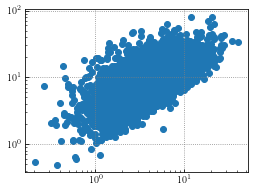

In [9]:
# Get mean merger rates in the (0.5,0.6) and (0.9,1.0) mass ratio intervals
ind_q05 = np.argmin(np.abs(qs-0.5))
ind_q06 = np.argmin(np.abs(qs-0.6))
ind_q09 = np.argmin(np.abs(qs-0.9))
ind_q10 = np.argmin(np.abs(qs-1.0))
mean_R_05_to_06 = np.trapz(dR_dqs[ind_q05:ind_q06,:],qs[ind_q05:ind_q06],axis=0)/(0.6-0.5)
mean_R_09_to_10 = np.trapz(dR_dqs[ind_q09:ind_q10,:],qs[ind_q09:ind_q10],axis=0)/(1.-0.9)

fig,ax = plt.subplots()
ax.scatter(mean_R_04_to_05,mean_R_09_to_10)
ax.set_xscale('log')
ax.set_yscale('log')
plt.show()

significance_q_increase = mean_R_09_to_10[mean_R_09_to_10>mean_R_04_to_05].size/mean_R_09_to_10.size

In [13]:
# Save macrofile
with open('./../macros/significance_q_features.txt','w') as macrofile:
    
    macrofile.write("\\newcommand{{\\MassRatioSignifanceRising}}{{{0:.0f}\\%}}".format(100.*significance_q_increase))
    macrofile.write("\n")
    
    # Also compute and save significance with which LVK parametric distribution finds the mass ratio distribution
    # to favor equal qs
    bqs = read_lvk_plpeak_data()['bq']
    significance_bq_positive = bqs[bqs>0].size/bqs.size
    macrofile.write("\\newcommand{{\\MassRatioBetaPositive}}{{{0:.0f}\\%}}".format(100.*significance_bq_positive))
    macrofile.write("\n")